In [58]:
import numpy as np
import pandas as pd

import joblib
import sqlite3
import operator as op

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from collections import defaultdict
from tqdm.notebook import tqdm

from utils.get_or_create_combined_database import get_or_create_combined_database
from utils.create_compound_key_and_index import create_compound_key_and_index

from concurrent.futures import ProcessPoolExecutor

from constants import DB_columns, GAME_AREA_WIDTH

from matplotlib import pyplot as plt

import os
from dotenv import load_dotenv
load_dotenv(verbose=True, override=True)

RECREATE_CLEANED_DATA = False

zoom_range = ((75, 14350), (75, 14350))
normalized_zoom_range = ((0, 1), (0, 1))

In [2]:
database_folder = os.getenv("DATABASE_FOLDER")

database_file = get_or_create_combined_database(database_folder)

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

tlol_db_table_name = "champs"

page_size = 5

rows = cursor.execute(
    f"SELECT * FROM {tlol_db_table_name} LIMIT {page_size}").fetchall()
conn.close()
print(f"Loaded {len(rows)} rows from the database as a test")

rows[0:5]

Found 2 database files in the folder specified by DATABASE_FOLDER
Found combined database /u/23/tarpill1/unix/Documents/combined2.db
Loaded 5 rows from the database as a test


[('Mordekaiser',
  604.0,
  612.0,
  1.005585,
  645.0,
  100,
  2841236401,
  '2841236401_100_Mordekaiser'),
 ('Viego',
  664.0,
  286.0,
  1.005585,
  630.0,
  100,
  2841236401,
  '2841236401_100_Viego'),
 ('Riven',
  364.0,
  136.0,
  1.005585,
  645.0,
  100,
  2841236401,
  '2841236401_100_Riven'),
 ('Ezreal',
  132.0,
  402.0,
  1.005585,
  600.0,
  100,
  2841236401,
  '2841236401_100_Ezreal'),
 ('Leblanc',
  298.0,
  676.0,
  1.005585,
  598.0,
  100,
  2841236401,
  '2841236401_100_Leblanc')]

In [3]:
cleaned_table_name = f"{tlol_db_table_name}_cleaned"


# Create a new table for cleaned up data
if RECREATE_CLEANED_DATA:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

    # Drop previous table
    cursor.execute(f"DROP TABLE IF EXISTS {cleaned_table_name}")

    conn.commit()

    cursor.execute(
        f"CREATE TABLE {cleaned_table_name} AS SELECT * FROM {tlol_db_table_name} WHERE 1=0")

    # Add normalized columns

    cursor.execute(
        f"ALTER TABLE {cleaned_table_name} ADD COLUMN {DB_columns.NORMALIZED_POS_X.value} FLOAT GENERATED ALWAYS AS ({DB_columns.POS_X.value} / {GAME_AREA_WIDTH}) STORED")
    cursor.execute(
        f"ALTER TABLE {cleaned_table_name} ADD COLUMN {DB_columns.NORMALIZED_POS_Z.value} FLOAT GENERATED ALWAYS AS ({DB_columns.POS_Z.value} / {GAME_AREA_WIDTH}) STORED")
    conn.commit()
    conn.close()

In [4]:
# Add data to the new table from original table according to a filter

# Conditions:
# Only rows with a name that is not empty
not_empty_name = f"{DB_columns.NAME.value} IS NOT ''"

# Only rows with a name that is not "Turret"

# Only rows with timestamp greater than 5
timestamp_greater_than_5 = f"{DB_columns.TIME.value} > 5"

# Only rows with pos_x and pos_y greater between [0, GAME_AREA_WIDTH]
pos_x_greater_than_0 = f"{DB_columns.POS_X.value} > 0"
pos_x_less_than_max = f"{DB_columns.POS_X.value} < {GAME_AREA_WIDTH}"
pos_z_greater_than_0 = f"{DB_columns.POS_Z.value} > 0"
pos_z_less_than_max = f"{DB_columns.POS_Z.value} < {GAME_AREA_WIDTH}"
position_between_0_and_max = " AND ".join(
    [pos_x_greater_than_0, pos_x_less_than_max, pos_z_greater_than_0, pos_z_less_than_max])

# Combine all above filters

filter_conditions = " AND ".join(
    [not_empty_name, timestamp_greater_than_5, position_between_0_and_max])

In [5]:
# Add cleaned indices to new table
if RECREATE_CLEANED_DATA:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

    cursor.execute(
        f"INSERT INTO {cleaned_table_name} SELECT * FROM {tlol_db_table_name} WHERE {filter_conditions}")

    conn.commit()
    conn.close()

In [6]:
# Check values from the new table

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

page_size = 5

rows = cursor.execute(
    f"SELECT * FROM {cleaned_table_name} LIMIT {page_size}").fetchall()

conn.close()

rows

[('Mordekaiser',
  604.0,
  612.0,
  5.5419455,
  645.0,
  100,
  2841236401,
  '2841236401_100_Mordekaiser',
  0.040266666666666666,
  0.0408),
 ('Viego',
  786.0,
  436.0,
  5.5419455,
  630.0,
  100,
  2841236401,
  '2841236401_100_Viego',
  0.0524,
  0.029066666666666668),
 ('Riven',
  364.0,
  136.0,
  5.5419455,
  745.0,
  100,
  2841236401,
  '2841236401_100_Riven',
  0.024266666666666666,
  0.009066666666666667),
 ('Ezreal',
  132.0,
  402.0,
  5.5419455,
  600.0,
  100,
  2841236401,
  '2841236401_100_Ezreal',
  0.0088,
  0.0268),
 ('Leblanc',
  298.0,
  676.0,
  5.5419455,
  598.0,
  100,
  2841236401,
  '2841236401_100_Leblanc',
  0.019866666666666668,
  0.045066666666666665)]

In [7]:
# Create indices for given columns

conn = sqlite3.connect(database_file)
cursor = conn.cursor()


def create_index(cursor, table_name, column_name):
    if RECREATE_CLEANED_DATA:
        cursor.execute(
            f"DROP INDEX IF EXISTS {table_name}_{column_name}_index")
        cursor.execute(
            f"CREATE INDEX IF NOT EXISTS {table_name}_{column_name}_index ON {table_name}({column_name})")


columns_to_be_indexed = [DB_columns.NAME.value]

for column in columns_to_be_indexed:
    create_index(cursor, cleaned_table_name, column)
conn.commit()
conn.close()

# List out indices

conn = sqlite3.connect(database_file)
cursor = conn.cursor()


print(create_compound_key_and_index(database_file, cleaned_table_name, [
    DB_columns.GAME_ID.value, DB_columns.TEAM.value, DB_columns.NAME.value]))

indices = cursor.execute(
    f"PRAGMA index_list({cleaned_table_name})").fetchall()

table_info = cursor.execute(
    f"PRAGMA table_info({cleaned_table_name})").fetchall()

conn.close()

print(indices)
print(table_info)

Compound key and index created for table 'champs_cleaned' with key expression: game_id || '_' || team || '_' || name
[(0, 'champs_cleaned_name_index', 0, 'c', 0), (1, 'champs_cleaned_compound_key_idx', 0, 'c', 0)]
[(0, 'name', 'TEXT', 0, None, 0), (1, 'pos_x', 'REAL', 0, None, 0), (2, 'pos_z', 'REAL', 0, None, 0), (3, 'time', 'REAL', 0, None, 0), (4, 'hp', 'REAL', 0, None, 0), (5, 'team', 'INT', 0, None, 0), (6, 'game_id', 'INT', 0, None, 0), (7, 'compound_key', 'TEXT', 0, None, 0)]


In [8]:
def get_counts(cursor, table_name, filter):
    cursor.execute(
        f"SELECT COUNT(DISTINCT {DB_columns.COMPOUND_KEY.value}) FROM {table_name} WHERE {filter}")
    unique_keys = cursor.fetchone()[0]
    cursor.execute(
        f"SELECT COUNT(*), {DB_columns.COMPOUND_KEY.value} FROM {table_name} WHERE {filter} GROUP BY {DB_columns.COMPOUND_KEY.value} ORDER BY {DB_columns.COMPOUND_KEY.value}")
    counts = cursor.fetchall()
    return unique_keys, counts


conn = sqlite3.connect(database_file)
cursor = conn.cursor()

filter = "1=1"  # f"{DB_columns.NAME.value} = 'Ezreal'"

unique_keys, counts = get_counts(cursor, cleaned_table_name, filter)
conn.close()

offsets = []
cumulative_sum = 0

for count in counts:
    offsets.append(cumulative_sum)
    cumulative_sum += count[0]
offsets.append(cumulative_sum)

unique_keys, cumulative_sum

(100580, 65821670)

In [9]:
def get_data_by_compound_key(cursor, table_name, offset, limit, filter):
    return cursor.execute(
        f"SELECT {DB_columns.NORMALIZED_POS_Z.value}, {DB_columns.NORMALIZED_POS_X.value} FROM {table_name} WHERE {filter} ORDER BY {DB_columns.COMPOUND_KEY.value} LIMIT {limit} OFFSET {offset}"
    ).fetchall()


def get_data(cursor, table_name, offset, limit, counts, offsets, total, filter):
    all_rows = get_data_by_compound_key(
        cursor, table_name, offset, limit, filter)

    rows_per_key = defaultdict(list)

    for i in tqdm(range(total)):
        result_offset = offsets[i] - offset
        result_count = counts[i][0]
        key_slice = all_rows[result_offset:result_offset + result_count]
        if len(key_slice) > 0:
            rows_per_key[counts[i][1]].extend(key_slice)

    return rows_per_key


conn = sqlite3.connect(database_file)
cursor = conn.cursor()

# Adjust this based on the actual number of compound keys
total = int(unique_keys / 20)
total_count = offsets[total]

batches = min(total, 10)  # Update the number of batches as required

batch_key_counts = [int(total / batches)] * batches
batch_key_counts[-1] += total % batches

batch_offsets = []
batch_counts = []
batch_cumulative_sum = []
cumulative_sum = 0

for count in batch_key_counts:
    batch_offsets.append(offsets[cumulative_sum:count + cumulative_sum])
    batch_counts.append(counts[cumulative_sum:count + cumulative_sum])
    batch_cumulative_sum.append(cumulative_sum)
    cumulative_sum += count

rows_per_key = defaultdict(list)
with tqdm(total=total_count) as pbar:  # Adjust the progress bar total if needed
    for i in range(batches):
        offset = offsets[batch_cumulative_sum[i]]
        limit = offsets[batch_cumulative_sum[i] + batch_key_counts[i]] - offset
        keys_per_batch = batch_key_counts[i]

        offsets_of_batch = batch_offsets[i]
        counts_of_batch = batch_counts[i]

        batch_rows_per_key = get_data(
            cursor, cleaned_table_name, offset, limit, counts_of_batch, offsets_of_batch, keys_per_batch, filter)
        for key, rows in batch_rows_per_key.items():
            pbar.update(len(rows))
            rows_per_key[key].extend(rows)

conn.close()

print(f"Got {len(rows_per_key)} keys")

  0%|          | 0/3296345 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

Got 5029 keys


In [10]:
data = np.array(list(rows_per_key.values()), dtype=object)

In [11]:
def create_sequences(data, H, T):
    X, y = [], []
    for i in range(len(data) - H - T + 1):
        if i+H+T <= len(data):
            X.append(data[i:i+H])
            y.append(data[i+H+T-1:i+H+T])
    return X, y
# Similar to the above methods, let's now create a method that will create sequences using the data from the database with SQL queries


def create_sequences_from_database_rows(rows, H, T, show_progress=True):
    # Get counts of compound key
    X, y = [], []
    for row in tqdm(rows) if show_progress else rows:
        if len(row) < H+T:
            continue
        _X, _y = create_sequences(row, H, T)
        X.append(_X)
        y.append(_y)
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y


H = 3
T = 1

X, y = create_sequences_from_database_rows(data, H, T)


X.shape, y.shape

  0%|          | 0/5029 [00:00<?, ?it/s]

((3281258, 3, 2), (3281258, 1, 2))

Number of rows: 5029
Average number of rows in a group: 655.4672897196261
Number of sequences: 3281258
Average length of a sequence: 3


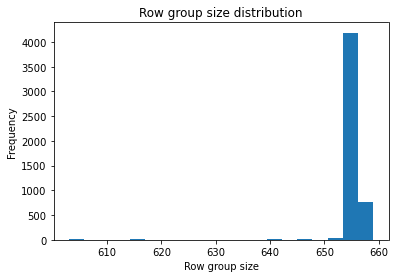

In [12]:
# Statistics about the data

# How many row groups are there?
print(f"Number of rows: {data.shape[0]}")

# How many rows in a group on average?
row_counts = [len(row) for row in data]
print(f"Average number of rows in a group: {np.mean(row_counts)}")

# Statistics about the sequences

# How many sequences are there?
print(f"Number of sequences: {X.shape[0]}")

# Plot the rows group sizes

plt.hist(row_counts, bins=20)
plt.xlabel('Row group size')
plt.ylabel('Frequency')
plt.title('Row group size distribution')
plt.show()

In [13]:
def split_data(X, y):
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=0.2, random_state=42, shuffle=False)
    # Flatten the input sequences
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(X, y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2625006, 6) (656252, 6) (2625006, 2) (656252, 2)


# Models

In [75]:
H = 2
T = 3

X, y = create_sequences_from_database_rows(data, H, T)
X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(X, y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

  0%|          | 0/5029 [00:00<?, ?it/s]

(2620983, 4) (2620983, 2)
(655246, 4) (655246, 2)


In [76]:
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2

In [77]:
# Create a model that predicts the next position by taking a random step in the direction of the average velocity
class RandomStepModel:
    def __init__(self, H, T):
        self.H = H
        self.T = T

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Assuming X_test shape is (num_samples, H*2)
        num_samples = X_test.shape[0]

        # Reshape X_test to (num_samples, H, 2)
        X_test_reshaped = X_test.reshape(num_samples, self.H, 2)

        # Get average velocity for each sequence
        avg_velocity = (
            X_test_reshaped[:, -1, :] - X_test_reshaped[:, 0, :]) / self.H

        # Calculate the length of the step for timestep T
        step = avg_velocity * self.T

        # Calculate a random direction for each sample
        direction = np.random.uniform(-1, 1, size=step.shape)

        # Normalize the direction to ensure the step size is consistent
        norms = np.linalg.norm(direction, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid division by zero
        direction /= norms

        # Calculate the random step
        random_step = step * direction

        # Get the last position in the sequence for each sample
        last_position = X_test_reshaped[:, -1, :]

        # Calculate the prediction
        y_pred = last_position + random_step

        return y_pred

In [78]:
# Create the model
random_step_model = RandomStepModel(H, T)

In [79]:
mse_random_walk, rmse_random_walk, r2_random_walk = calculate_metrics(
    random_step_model, X_test, y_test)


print(f'Mean Squared Error (Random Walk): {mse_random_walk}')
print(f'Root Mean Squared Error (Random Walk): {rmse_random_walk}')
print(f'R-squared (Random Walk): {r2_random_walk}')

# Visualize the random walk predictions
# create_prediction_animation(X_test, y_pred_random_walk, y_test, map_image_path, zoom_range, options)

Mean Squared Error (Random Walk): 0.0007258701864604271
Root Mean Squared Error (Random Walk): 0.02694197814675877
R-squared (Random Walk): 0.9900182747783741


In [80]:
# Create a model that selects the last position as the prediction

class LastPositionModel:
    def __init__(self, H):
        self.H = H

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Unflatten X_test
        X_test_reshaped = X_test.reshape(X_test.shape[0], self.H, 2)
        # Get the last position for each sequence
        return X_test_reshaped[:, -1, :]


# Create the model
last_position_model = LastPositionModel(H)

mse_last_position, rmse_last_position, r2_last_position = calculate_metrics(
    last_position_model, X_test, y_test)

print(f'Mean Squared Error (Last Position): {mse_last_position}')
print(f'Root Mean Squared Error (Last Position): {rmse_last_position}')
print(f'R-squared (Last Position): {r2_last_position}')

Mean Squared Error (Last Position): 0.0005439067371052687
Root Mean Squared Error (Last Position): 0.023321808186872402
R-squared (Last Position): 0.9925196593350671


In [81]:
# Create a model that selects a random position from a given range as the prediction

class RandomPositionModel:
    def __init__(self, H, range_x, range_y):
        self.H = H
        self.range_x = range_x
        self.range_y = range_y

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Generate random positions for each sequence
        x = np.random.uniform(
            self.range_x[0], self.range_x[1], size=X_test.shape[0])
        y = np.random.uniform(
            self.range_y[0], self.range_y[1], size=X_test.shape[0])
        return np.array(list(zip(x, y)))


range_x = (0, 1)
range_y = (0, 1)

random_position_model = RandomPositionModel(H, range_x, range_y)

mse_random_position, rmse_random_position, r2_random_position = calculate_metrics(
    random_position_model, X_test, y_test)

print(f'Mean Squared Error (Random Position): {mse_random_position}')
print(f'Root Mean Squared Error (Random Position): {rmse_random_position}')
print(f'R-squared (Random Position): {r2_random_position}')

Mean Squared Error (Random Position): 0.1577914193008409
Root Mean Squared Error (Random Position): 0.3972296807903973
R-squared (Random Position): -1.1712192298443136


In [88]:
class ContinuousMotionModel:
    def __init__(self, H, T):
        self.H = H
        self.T = T

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Assuming X_test shape is (num_samples, H*2)
        num_samples = X_test.shape[0]

        # Reshape X_test to (num_samples, H, 2)
        X_test_reshaped = X_test.reshape(num_samples, self.H, 2)

        # Create weights that increase linearly
        weights = np.linspace(1, 2, self.H)  # Example: weights from 1 to 2
        weights /= weights.sum()  # Normalize weights to sum to 1

        # Get weighted average velocity for each sequence
        weighted_positions = X_test_reshaped * weights[:, np.newaxis]
        weighted_avg_velocity = (
            weighted_positions.sum(axis=1) - X_test_reshaped[:, 0, :]
        ) / self.H

        # Calculate the length of the step for timestep T
        step = weighted_avg_velocity * self.T

        # Get the last position in the sequence for each sample
        last_position = X_test_reshaped[:, -1, :]

        # Calculate the prediction
        y_pred = last_position + step

        return y_pred

In [89]:
continuous_motion_model = ContinuousMotionModel(H, T)

mse_continuous_motion, rmse_continuous_motion, r2_continuous_motion = calculate_metrics(
    continuous_motion_model, X_test, y_test)

print(f'Mean Squared Error (Continuous Motion): {mse_continuous_motion}')
print(f'Root Mean Squared Error (Continuous Motion): {rmse_continuous_motion}')
print(f'R-squared (Continuous Motion): {r2_continuous_motion}')

Mean Squared Error (Continuous Motion): 0.0006461058959709354
Root Mean Squared Error (Continuous Motion): 0.025418613179537065
R-squared (Continuous Motion): 0.9911152412436164


# Model Comparison

In [62]:
def calculate_sequences_in_batches(H_values, T_values, data, batch_size=1000, split=True, test_size=0.2, random_state=None, show_progress=True):
    sequences = {}

    def create_sequences(data, H, T):
        num_sequences = len(data) - H - T + 1
        if num_sequences <= 0:
            return np.array([]), np.array([])

        X = np.lib.stride_tricks.sliding_window_view(
            data, window_shape=(H, data.shape[1]))[:-T]
        y = data[H+T-1:num_sequences+H+T-1]

        return X, y

    def create_sequences_from_database_rows(rows, H, T):
        X_list, y_list = [], []
        for i in range(0, len(rows), batch_size):
            batch = rows[i:i+batch_size]
            for row in batch:
                if len(row) < H + T:
                    continue
                _X, _y = create_sequences(np.array(row), H, T)
                if _X.size > 0 and _y.size > 0:
                    X_list.append(_X)
                    y_list.append(_y)

        if X_list and y_list:
            X = np.concatenate(X_list, axis=0)
            y = np.concatenate(y_list, axis=0)
        else:
            X, y = np.array([]), np.array([])

        return X, y

    for H in tqdm(H_values, desc='H loop', leave=False):
        for T in tqdm(T_values, desc='T loop', leave=False):
            X, y = create_sequences_from_database_rows(data, H, T)
            if X.size > 0 and y.size > 0:
                if split:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=test_size, random_state=random_state)
                    sequences[(H, T)] = (X_train, X_test, y_train, y_test)
                else:
                    sequences[(H, T)] = (X, None, y, None)
            else:
                sequences[(H, T)] = (None, None, None, None)

    return sequences

In [101]:
# Compare all four models

def compare_models(H_values, T_values, data, model_getters, train=True):
    absolute_errors = defaultdict(list)
    rmse_results = defaultdict(int)
    trained_models = {}
    pbar = tqdm(total=len(H_values) * len(T_values) *
                len(model_getters), desc='Model loop')
    for H in H_values:
        for T in tqdm(T_values, desc=f'H={H}', leave=False):
            # Calculate the sequence on the fly
            sequence = calculate_sequences_in_batches(
                [H], [T], data, split=False, show_progress=False)[(H, T)]
            X_train, X_test, y_train, y_test = sequence
            models = {model_name: model_getter(
                H, T) for model_name, model_getter in model_getters.items()}
            for model_name, model in tqdm(models.items(), desc=f'T={T}', leave=False):
                X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
                model.fit(X_train_reshaped, y_train)
                y_pred = model.predict(X_train_reshaped)
                rmse = root_mean_squared_error(y_train, y_pred)
                rmse_results[(H, T, model_name)] += rmse
                absolute_errors[(H, T, model_name)] = np.abs(y_train - y_pred)
                if train:
                    trained_models[(H, T, model_name)] = model
                pbar.update(1)
    pbar.close()
    return trained_models, rmse_results, absolute_errors

In [152]:
# H values on a logarithmic scale
H_values = [100, 200, 300]
T_values = [50, 100, 150]

# sequence_data = calculate_sequences_in_batches(H_values, T_values, data)

# print(f"Calculated sequences for {len(sequence_data)} combinations of H and T")

In [153]:
model_getters = {
    # 'Linear Model': lambda H, T: LinearRegression(),
    # 'Random Step Model': lambda H, T: RandomStepModel(H, T),
    'Last Position Model': lambda H, T: LastPositionModel(H),
    # 'Random Position Model': lambda H, T: RandomPositionModel(H, normalized_zoom_range[0], normalized_zoom_range[1]),
    # 'Continuous Motion Model': lambda H, T: ContinuousMotionModel(H, T)
}

In [154]:
trained_models, rmse_results, absolute_errors = compare_models(
    H_values, T_values, data, model_getters)

results_table = pd.DataFrame(rmse_results, index=['Root Mean Squared Error']).T
results_table.index.names = ['H', 'T', 'Model']
results_table = results_table.sort_index()
results_table

Model loop:   0%|          | 0/9 [00:00<?, ?it/s]

H=100:   0%|          | 0/3 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=50:   0%|          | 0/1 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=100:   0%|          | 0/1 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=150:   0%|          | 0/1 [00:00<?, ?it/s]

H=200:   0%|          | 0/3 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=50:   0%|          | 0/1 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=100:   0%|          | 0/1 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=150:   0%|          | 0/1 [00:00<?, ?it/s]

H=300:   0%|          | 0/3 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=50:   0%|          | 0/1 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=100:   0%|          | 0/1 [00:00<?, ?it/s]

H loop:   0%|          | 0/1 [00:00<?, ?it/s]

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

T=150:   0%|          | 0/1 [00:00<?, ?it/s]

Root Mean Squared Error
H   T   Model                                       
100 50  Last Position Model                 0.105613
    100 Last Position Model                 0.144080
    150 Last Position Model                 0.165712
200 50  Last Position Model                 0.098964
    100 Last Position Model                 0.135825
    150 Last Position Model                 0.159395
300 50  Last Position Model                 0.093700
    100 Last Position Model                 0.127286
    150 Last Position Model                 0.145668

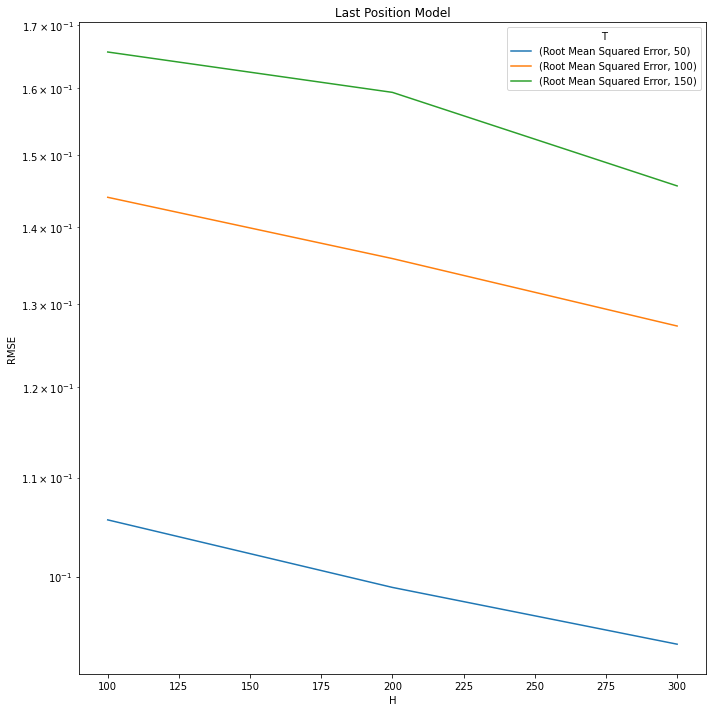

In [155]:
LOG_PLOT = True

# Plot the results table, one table per model
subplot_amount = len(model_getters)
# If just a single value combination per model, plot them all in a bar chart
if len(H_values) == 1 and len(T_values) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    results_table.unstack().plot(ax=ax, kind='bar', logy=LOG_PLOT)
    ax.set_xlabel('H')
    ax.set_ylabel('RMSE')
    ax.legend(title='T')
else:
    # If just one T value, plot all models in the same plot
    if len(T_values) == 1:
        # The X-axis is currently tuple, take the first value only to have a single value
        results_table.xs(T_values[0], level='T').unstack().plot(
            kind='line', logy=LOG_PLOT)

        plt.xlabel('H')
        plt.ylabel('RMSE')
        plt.legend(title='T')
    elif len(H_values) == 1:
        # If just one H value, plot all models in the same plot
        results_table.xs(H_values[0], level='H').unstack().plot(
            kind='line', logy=LOG_PLOT)

        plt.xlabel('T')
        plt.ylabel('RMSE')
        plt.legend(title=f'H={H_values[0]}')
    else:
        fig, axs = plt.subplots(
            subplot_amount, 1, figsize=(10, 10*subplot_amount))
        for i, model_name in enumerate(model_getters.keys()):
            # Plot the results for the model, H on the x-axis, RMSE on the y-axis, and different lines for different T
            results_table.xs(model_name, level='Model').unstack().plot(
                ax=axs[i] if subplot_amount > 1 else axs, title=model_name, logy=LOG_PLOT)
            (axs[i] if subplot_amount > 1 else axs).set_xlabel('H')
            (axs[i] if subplot_amount > 1 else axs).set_ylabel('RMSE')
            (axs[i] if subplot_amount > 1 else axs).legend(title='T')

plt.tight_layout()

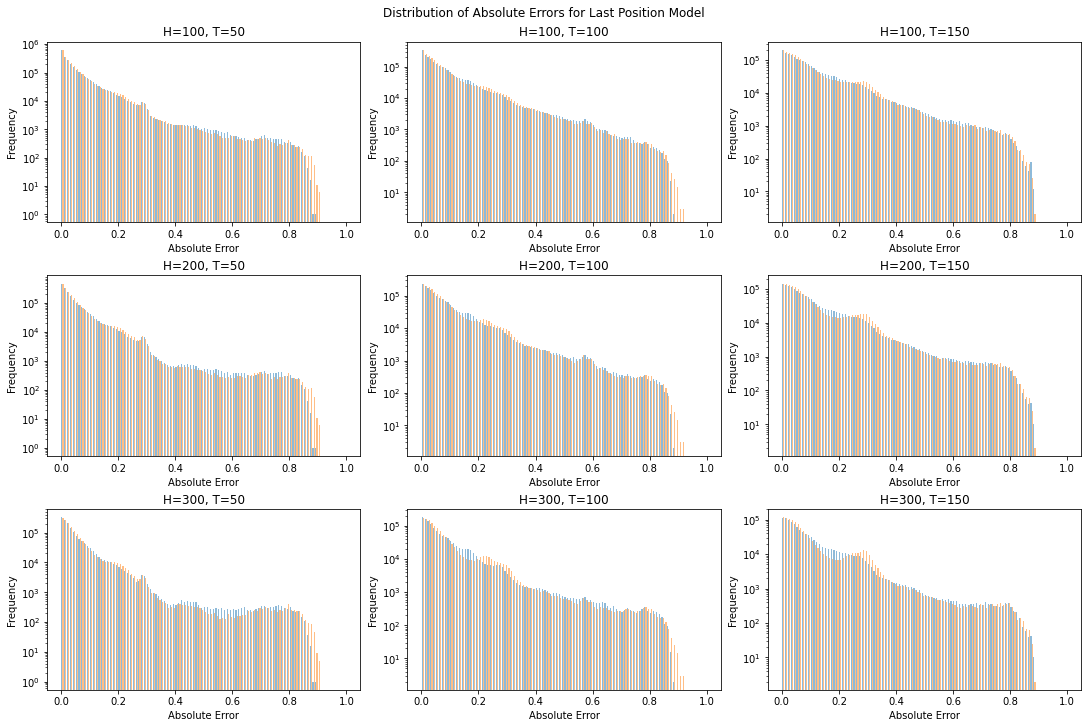

In [181]:
# Plot the distribution of absolute errors for each model
if len(H_values) == 1 and len(T_values) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for (H, T, name), errors in absolute_errors.items():
        errors = errors.flatten()
        ax.hist(errors, bins=100, alpha=0.5,
                label=f'H={H}, T={T}', range=(0, 1), log=True)
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.legend()
elif len(T_values) == 1:
    fig, axs = plt.subplots(
        len(H_values), 1, figsize=(10, 10*len(H_values)))
    for i, model_name in enumerate(model_getters.keys()):
        for (H, T, name), errors in [item for item in absolute_errors.items() if item[0][2] == model_name]:
            errors = errors.flatten()
            axs[i].hist(errors, bins=100, alpha=0.5,
                        label=f'{name} H={H}', range=(0, 1), log=True)
        axs[i].set_title(f'{model_name}')
        axs[i].set_xlabel('Absolute Error')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
elif len(H_values) == 1:
    fig, axs = plt.subplots(
        len(T_values), 1, figsize=(10, 10*len(T_values)))
    for i, model_name in enumerate(model_getters.keys()):
        for (H, T, name), errors in [item for item in absolute_errors.items() if item[0][2] == model_name]:
            errors = errors.flatten()
            axs[i].hist(errors, bins=100, alpha=0.5,
                        label=f'{name} T={T}', range=(0, 1), log=True)
        axs[i].set_title(f'{model_name}')
        axs[i].set_xlabel('Absolute Error')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
else:
    for i, model_name in enumerate(model_getters.keys()):
        # Determine the number of rows and columns for the subplots
        num_rows = len(H_values)
        num_cols = len(T_values)

        # Create a figure and a grid of subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(
            15, 10), constrained_layout=True)

        for i, H in enumerate(H_values):
            for j, T in enumerate(T_values):
                ax = axs[i, j]
                errors = absolute_errors[(H, T, model_name)]
                ax.hist(errors, bins=100, alpha=0.5, range=(0, 1), log=True)
                ax.set_title(f'H={H}, T={T}')
                ax.set_xlabel('Absolute Error')
                ax.set_ylabel('Frequency')

        plt.suptitle('Distribution of Absolute Errors for ' + model_name)
        plt.show()

In [157]:
# Animate first 5 predictions for each model

def create_prediction_animation_for_models(trained_models, data, map_image_path, zoom_range, options={}):
    """
    Create an animation of the player positions and future predictions on the map for each model.

    Args:
    trained_models (dict): A dictionary of trained models
    H (int): The length of the input sequence
    T (int): The length of the target sequence
    data (dict): A dictionary of games
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
        - speed (int): The speed of the animation
    """
    for i, (model_name, model) in enumerate(trained_models.items()):
        H, T, _ = model_name
        X_train, X_test, y_train, y_test, _, _ = sequence_data[(H, T)]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        options['title'] = model_name
        create_prediction_animation(
            X_test, y_pred, y_test, map_image_path, zoom_range, options)
    plt.tight_layout()


# create_prediction_animation_for_models(
#     trained_models, data, map_image_path, zoom_range, options)

In [158]:
# Save models to disk

for (H, T, model_name), model in trained_models.items():
    joblib.dump(
        model, f'models/{model_name.replace(" ", "_")}_H_{H}_T_{T}.joblib')

In [159]:
# Load models from disk - get models and load them into the trained_models dictionary

# Get all H and T values from the file names
import os
import re

loaded_models = {}

model_files = os.listdir('models')
model_files = [file for file in model_files if file.endswith('.joblib')]
pattern = re.compile(r'(\w+)_(\d+)_(\d+).joblib')
for file in model_files:
    match = pattern.match(file)
    if match:
        model_name, H, T = match.groups()
        H = int(H)
        T = int(T)
        model = joblib.load(f'models/{file}')
        loaded_models[(H, T, model_name)] = model

In [160]:
# Create a small example prediction animation for each model
# example_data = data[:5]

# trained_models = {key: trained_models[key]
#                   for key in list(trained_models.keys())[:4]}
# create_prediction_animation_for_models(
#     trained_models, example_data, map_image_path, zoom_range, options)